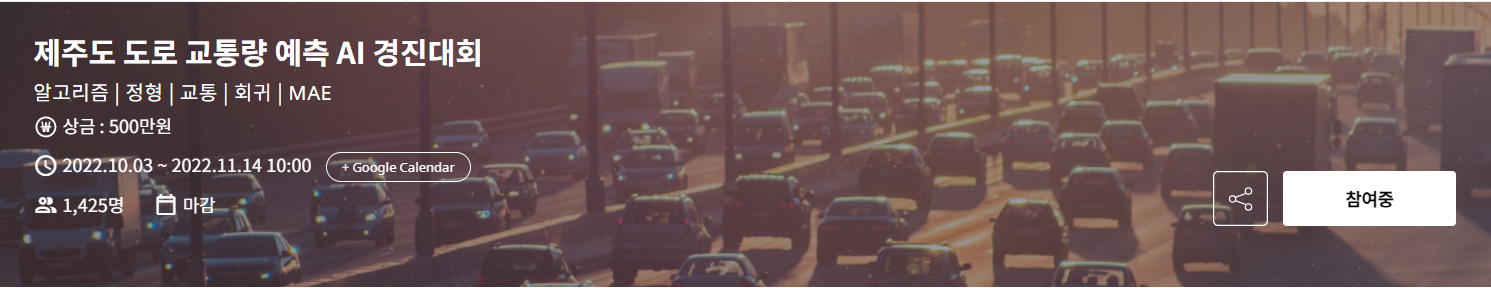

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 5 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 2s (3,943 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype

In [ ]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 348 kB 4.0 MB/s 
     |████████████████████████████████| 81 kB 8.6 MB/s 
     |████████████████████████████████| 209 kB 63.9 MB/s 
     |████████████████████████████████| 78 kB 1.1 MB/s 
     |████████████████████████████████| 112 kB 55.8 MB/s 
     |████████████████████████████████| 50 kB 6.2 MB/s 
     |████████████████████████████████| 147 kB 56.3 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=d0f15aa221cf0a5f828c52fc56ca4b7d4bae36c53636b8d58b16643cab2d87cb
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [ ]:
!pip install haversine

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# 데이터분석 4종 세트
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from haversine import haversine

# 모델들, 성능 평가
# (저는 일반적으로 정형데이터로 머신러닝 분석할 때는 이 2개 모델은 그냥 돌려봅니다. 특히 RF가 테스트하기 좋습니다.)
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from lightgbm.sklearn import LGBMClassifier
from lightgbm.sklearn import LGBMRegressor

# 상관관계 분석, VIF : 다중공선성 제거
from statsmodels.stats.outliers_influence import variance_inflation_factor

# KFold(CV), partial : optuna를 사용하기 위함
from sklearn.model_selection import KFold
from functools import partial
from sklearn.metrics import mean_absolute_error

# hyper-parameter tuning을 위한 라이브러리, optuna
import optuna

plt.rc('font', family='NanumBarunGothic') 
from collections import Counter

In [ ]:
plt.rc('font', family='NanumBarunGothic') 

In [ ]:
data_path = '/content/drive/MyDrive/Colab Notebooks/data/open/'

In [ ]:
data_info_df = pd.read_csv(data_path + 'data_info.csv')
test_df = pd.read_csv(data_path + 'test.csv')
train_df = pd.read_csv(data_path + 'train.csv')

In [ ]:
train_df.base_date = pd.to_datetime(train_df.base_date, format='%Y%m%d')
train_df.day_of_week = train_df.base_date.dt.day_of_week

test_df.base_date = pd.to_datetime(test_df.base_date, format='%Y%m%d')
test_df.day_of_week = test_df.base_date.dt.day_of_week


In [ ]:
train_df.info()
# object 타입의 칼럼이 존재 -> 해당 부분 전처리 생각하기

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4701217 entries, 0 to 4701216
Data columns (total 23 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   id                     object        
 1   base_date              datetime64[ns]
 2   day_of_week            int64         
 3   base_hour              int64         
 4   lane_count             int64         
 5   road_rating            int64         
 6   road_name              object        
 7   multi_linked           int64         
 8   connect_code           int64         
 9   maximum_speed_limit    float64       
 10  vehicle_restricted     float64       
 11  weight_restricted      float64       
 12  height_restricted      float64       
 13  road_type              int64         
 14  start_node_name        object        
 15  start_latitude         float64       
 16  start_longitude        float64       
 17  start_turn_restricted  object        
 18  end_node_name         

In [ ]:
# 결측치 확인
train_df.loc[train_df.isnull().any(axis = 1)]

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,...,road_type,start_node_name,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,target


In [ ]:
train_df.weight_restricted.value_counts()

0.0        4032874
43200.0     410361
32400.0     239305
50000.0      18677
Name: weight_restricted, dtype: int64

In [ ]:
def f(x):
  if x=='없음':
    return 0
  else:
    return 1

In [ ]:
train_df.start_turn_restricted = train_df.start_turn_restricted.apply(f)
train_df.end_turn_restricted = train_df.end_turn_restricted.apply(f)

In [ ]:
train_df.end_turn_restricted.value_counts()

0    4239599
1     461618
Name: end_turn_restricted, dtype: int64

In [ ]:
test_df.start_turn_restricted = test_df.start_turn_restricted.apply(f)
test_df.end_turn_restricted = test_df.end_turn_restricted.apply(f)

In [ ]:
(train_df.target - train_df.maximum_speed_limit).mean()

-18.46485069717054

In [ ]:
day_of_week = [i for i in range(7)]

In [ ]:
cctv = pd.read_csv(data_path + '전국무인교통단속카메라표준데이터.csv', encoding='cp949')

In [ ]:
cctv = cctv.drop(columns=['무인교통단속카메라관리번호']).loc[cctv['시도명']=='제주특별자치도']

In [ ]:
cctv.columns

Index(['시도명', '시군구명', '도로종류', '도로노선번호', '도로노선명', '도로노선방향', '소재지도로명주소',
       '소재지지번주소', '위도', '경도', '설치장소', '단속구분', '제한속도', '단속구간위치구분', '과속단속구간길이',
       '보호구역구분', '설치연도', '관리기관명', '관리기관전화번호', '데이터기준일자', '제공기관코드', '제공기관명'],
      dtype='object')

In [ ]:
cctv = cctv[['시군구명', '위도', '경도', '도로노선명', '도로노선방향', '보호구역구분', '설치연도']]

In [ ]:
cctv.loc[cctv.isnull().any(axis=1)]

,시군구명,위도,경도,도로노선명,도로노선방향,보호구역구분,설치연도
8467,서귀포시,33.300907,126.719507,남조로,01,NaN,2021.0
8468,서귀포시,33.239707,126.233588,일주서로,01,NaN,2021.0
8469,서귀포시,33.250412,126.303975,일주서로,01,NaN,2021.0
8470,제주시,33.447728,126.555973,516로,02,NaN,2021.0
8471,제주시,33.388584,126.376083,산록서로,02,NaN,2022.0
...,...,...,...,...,...,...,...
8923,제주시,33.495281,126.585021,번영로,01,NaN,2013.0
8927,서귀포시,33.288991,126.351411,한창로,02,NaN,2014.0
8928,서귀포시,33.292441,126.352361,한창로,01,NaN,2014.0
8929,제주시,33.298081,126.184501,일주서로,01,NaN,2013.0


In [ ]:
cctv.isnull().sum()

시군구명        0
위도          0
경도          0
도로노선명       0
도로노선방향      0
보호구역구분    211
설치연도        0
dtype: int64

In [ ]:
child = pd.read_csv(data_path + '제주특별자치도_어린이보호구역내_어린이승하차구역_20201231.csv')

In [ ]:
child.columns

Index(['관리번호', '시도명', '시군구명', '도로명', '보차분리여부', '어린이 승하차 구역 폭', '시작점위도',
       '시작점경도', '종료점위도', '종료점경도', '관리기관명', '관리기관전화번호', '데이터기준일자'],
      dtype='object')

In [ ]:
child = child[['도로명', '시작점위도', '시작점경도', '종료점위도', '종료점경도']]

In [ ]:
child_start = child[['시작점위도', '시작점경도']]
child_end = child[['종료점위도', '종료점경도']]

In [ ]:
tour = pd.read_csv(data_path + '제주관광공사_제주관광정보시스템(VISIT JEJU)_콘텐츠_20220322.csv', encoding='cp949')

In [ ]:
tour.columns

Index(['콘텐츠ID', '콘텐츠분류', '제목', '언어', '타이틀SEO', '연관콘텐츠', '지번주소', '도로명주소', '위도',
       '경도', '탐나오연동여부', '평점', '소셜네트워크URL', '조회수', '외부검색어', '좋아요수', '리뷰수',
       '북마크수', '일정등록수', '다녀왔어요수', 'PC사용여부', '모바일사용여부', '공개여부', '작성상태', '사용여부',
       '작성상태_1', '영문PC사용여부', '중문PC사용여부', '일문PC사용여부', '영문작성상태', '중문작성상태',
       '일문작성상태', '영문공개여부', '중문공개여부', '일문공개여부', '영문모바일사용여부', '중문모바일사용여부',
       '일문모바일사용여부', '영문승인일시', '중문승인일시', '일문승인일시', '등록자', '등록일시', '수정자', '수정일시',
       'SNS공유수', '인기점수', '등록일시_1', '우편번호', '템플릿여부', '번역요청일시', '영문번역요청일시',
       '중문번역요청일시', '일문번역요청일시', '페이지SEO자동여부', '영문페이지SEO자동여부', '중문페이지SEO자동여부',
       '일문페이지SEO자동여부', '사진공유수', '번체PC사용여부', '말레이어PC사용여부', '번체작성상태', '말레이어작성상태',
       '번체공개여부', '말레이어공개여부', '번체모바일사용여부', '말어모바일사용여부', '번체승인일시', '말레이어승인일시',
       '번체번역요청일시', '말레이어번역요청일시', '번체SEO자동여부', '말레이어SEO자동여부'],
      dtype='object')

In [ ]:
tour = tour[['위도', '경도']]
#tour.loc[tour.isnull().any(axis=1)]

In [ ]:
tour.isnull().count()

위도    5780
경도    5780
dtype: int64

In [ ]:
tour = tour.dropna()

In [ ]:
parking = pd.read_csv(data_path + '전국주차장정보표준데이터.csv', encoding='cp949')

In [ ]:
parking = parking.loc[parking['제공기관명'].str.contains('제주')]

In [ ]:
parking.columns

Index(['주차장관리번호', '주차장명', '주차장구분', '주차장유형', '소재지도로명주소', '소재지지번주소', '주차구획수',
       '급지구분', '부제시행구분', '운영요일', '평일운영시작시각', '평일운영종료시각', '토요일운영시작시각',
       '토요일운영종료시각', '공휴일운영시작시각', '공휴일운영종료시각', '요금정보', '주차기본시간', '주차기본요금',
       '추가단위시간', '추가단위요금', '1일주차권요금적용시간', '1일주차권요금', '월정기권요금', '결제방법', '특기사항',
       '관리기관명', '전화번호', '위도', '경도', '데이터기준일자', '제공기관코드', '제공기관명'],
      dtype='object')

In [ ]:
parking[['위도', '경도']].loc[parking[['위도', '경도']].isnull().any(axis=1)]

,위도,경도
12745,NaN,NaN
12801,33.493556,NaN
12848,33.473555,NaN
12960,33.486694,NaN
12966,33.503305,NaN
12970,33.555303,NaN
12971,NaN,126.300444
12977,NaN,NaN
12978,NaN,NaN


In [ ]:
parking = parking[['위도', '경도']].dropna()

In [ ]:
crosswalk = pd.read_csv(data_path + '제주특별자치도_어린이보호구역내_횡단보도_12_31_2020.csv')
crosswalk.columns

Index(['관리번호', '시도명', '시군구명', '도로명', '소재지도로명주소', '소재지지번주소', '횡단보도관리번호',
       '횡단보도종류', '자전거횡단도겸용여부', '고원식적용여부', '위도', '경도', '차로수', '횡단보도폭', '횡단보도연장',
       '보행자신호등유무', '보행자작동신호기유무', '음향신호기설치여부', '교통섬유무', '보도턱낮춤여부', '점자블록유무',
       '집중조명시설유무', '관리기관명', '관리기관전화번호', '데이터기준일자'],
      dtype='object')

In [ ]:
def cal_dist(x1, y1, x2, y2, a, b):
    
    area = abs((x1 - a) * (y2 - b) - (y1 - b) * (x2 - a))
    AB = ((x1 - x2) ** 2 + (y1 - y2) ** 2) ** 0.5
    distance = area / AB
    return distance

def get_node_cnt(gps_values, infra_values) :
    cnt = []
    for y1, x1, y2, x2 in gps_values.values :
        i = 0
        for a, b in infra_values.values :
            dist = cal_dist(x1, y1, x2, y2, a, b)
            if dist < 0.0005 :
                i += 1
            else :
                pass
        cnt.append(i)
    return cnt

In [ ]:
gps_comb = train_df[['start_latitude', 'start_longitude', 'end_latitude', 'end_longitude']].drop_duplicates()

In [ ]:
cctv_cnt = get_node_cnt(gps_comb, cctv[['경도', '위도']])
child_start_cnt = get_node_cnt(gps_comb, child_start[['시작점경도', '시작점위도']])
child_end_cnt = get_node_cnt(gps_comb, child_end[['종료점경도', '종료점위도']])
tour_cnt = get_node_cnt(gps_comb, tour[['경도', '위도']])
parking_cnt = get_node_cnt(gps_comb, parking[['경도', '위도']])
crosswalk_cnt = get_node_cnt(gps_comb, crosswalk[['경도', '위도']])

In [ ]:
gps_comb['cctv_cnt'] = cctv_cnt
gps_comb['child_start_cnt'] = child_start_cnt
gps_comb['child_end_cnt'] = child_end_cnt
gps_comb['tour_cnt'] = tour_cnt
gps_comb['parking_cnt'] = parking_cnt
gps_comb['crosswalk_cnt'] = crosswalk_cnt

In [ ]:
train_df = pd.merge(train_df, gps_comb, how = 'left')
test_df = pd.merge(test_df, gps_comb, how = 'left').fillna(0)

In [ ]:
jeju = 33.506683, 126.493177

In [ ]:
train_df['j_a_dist'] = [haversine((v[0], v[1]), jeju, unit = 'km') for v in train_df[['start_latitude', 'start_longitude']].values]
test_df['j_a_dist'] = [haversine((v[0], v[1]), jeju, unit = 'km') for v in test_df[['start_latitude', 'start_longitude']].values]

In [ ]:
hanla = 33.36168194, 126.5291548

In [ ]:
train_df['h_a_dist'] = [haversine((v[0], v[1]), hanla, unit = 'km') for v in train_df[['start_latitude', 'start_longitude']].values]
test_df['h_a_dist'] = [haversine((v[0], v[1]), hanla, unit = 'km') for v in test_df[['start_latitude', 'start_longitude']].values]

In [ ]:
train_date = train_df.base_date.dt.strftime('%m%d')
test_date = test_df.base_date.dt.strftime('%m%d')

In [ ]:
holiday = ['1231', '0101', '0102', '0129', '0130', '0131', '0201', '0202', '0228', '0229', '0230', '0301', '0302', 
          '0505', '0506', '0507', '0508', '0605', '0607', '0606', '0814', '0815', '0816', '0920', '0921', '0504',
          '0922', '1002', '1003', '1004', '1008', '1009', '1010', '1224', '1225', '1226']

In [ ]:
def isTrue(x):
  if x:
    return 1
  else:
    return 0

train_df['holiday'] = train_date.isin(holiday).apply(isTrue)
test_df['holiday'] = test_date.isin(holiday).apply(isTrue)

In [ ]:
train_df = train_df.drop(index=train_df.loc[((train_df.maximum_speed_limit==70.0)&(train_df.target>90))].index)

In [ ]:
train_df = train_df.drop(index=train_df.loc[((train_df.maximum_speed_limit==60.0)&(train_df.target>90))].index)

In [ ]:
train_df = train_df.drop(index=train_df.loc[((train_df.maximum_speed_limit==50.0)&(train_df.target>80))].index)

In [ ]:
train_df = train_df.drop(index=train_df.loc[((train_df.maximum_speed_limit==80.0)&(train_df.target<10))].index)

In [ ]:
train_df = train_df.drop(index=train_df.loc[((train_df.maximum_speed_limit==40.0)&(train_df.target<20))].index)

In [ ]:
train_df = train_df.drop(index=train_df.loc[((train_df.lane_count==1)&(train_df.target<10))].index)

In [ ]:
train_df = train_df.drop(index=train_df.loc[((train_df.lane_count==2)&(train_df.target>100))].index)

In [ ]:
train_df = train_df.drop(index=train_df.loc[((train_df.lane_count==3)&(train_df.target>80))].index)

In [ ]:
train_df = train_df.drop(index=train_df.loc[((train_df.lane_count==1)&(train_df.target>100))].index)

In [ ]:
train_df = train_df.drop(index=train_df.loc[((train_df.road_type==3)&(train_df.target>80))].index)

In [ ]:
train_df = train_df.drop(index=train_df.loc[((train_df.start_turn_restricted==0)&(train_df.target>80))].index)
train_df = train_df.drop(index=train_df.loc[((train_df.start_turn_restricted==1)&(train_df.target>80))].index)
train_df = train_df.drop(index=train_df.loc[((train_df.road_type==0)&(train_df.target>80))].index)
train_df = train_df.drop(index=train_df.loc[((train_df.weight_restricted==43200.0)&(train_df.target<20))].index)
train_df = train_df.drop(index=train_df.loc[((train_df.weight_restricted==50000.0)&(train_df.target<30))].index)
train_df = train_df.drop(index=train_df.loc[((train_df.weight_restricted==50000.0)&(train_df.target>65))].index)
train_df = train_df.drop(index=train_df.loc[((train_df.weight_restricted==0.0)&(train_df.target>80))].index)
train_df = train_df.drop(index=train_df.loc[((train_df.maximum_speed_limit==60.0)&(train_df.target>80))].index)
train_df = train_df.drop(index=train_df.loc[((train_df.maximum_speed_limit==70.0)&(train_df.target>80))].index)
train_df = train_df.drop(index=train_df.loc[((train_df.maximum_speed_limit==40.0)&(train_df.target>80))].index)
train_df = train_df.drop(index=train_df.loc[((train_df.maximum_speed_limit==30.0)&(train_df.target<10))].index)
train_df = train_df.drop(index=train_df.loc[((train_df.connect_code==0)&(train_df.target>80))].index)
train_df = train_df.drop(index=train_df.loc[((train_df.multi_linked==0)&(train_df.target>80))].index)

In [ ]:
train_df.loc[(train_df["start_node_name"] == "송목교") & (train_df["road_name"] == "-"), "road_name"] = "중문로"
train_df.loc[(train_df["start_node_name"] == "남수교") & (train_df["road_name"] == "-"), "road_name"] = "중문로"
train_df.loc[(train_df["start_node_name"] == "하귀입구") & (train_df["road_name"] == "-"), "road_name"] = "일반국도12호선"
train_df.loc[(train_df["start_node_name"] == "양계장") & (train_df["road_name"] == "-"), "road_name"] = "일반국도12호선"
train_df.loc[(train_df["start_node_name"] == "난산입구") & (train_df["road_name"] == "-"), "road_name"] = "지방도1119호선"
train_df.loc[(train_df["start_node_name"] == "영주교") & (train_df["road_name"] == "-"), "road_name"] = "일반국도11호선"
train_df.loc[(train_df["start_node_name"] == "서중2교") & (train_df["road_name"] == "-"), "road_name"] = "중문로"
train_df.loc[(train_df["start_node_name"] == "천제이교") & (train_df["road_name"] == "-"), "road_name"] = "산서로"
train_df.loc[(train_df["start_node_name"] == "하나로교") & (train_df["road_name"] == "-"), "road_name"] = "중문로"
train_df.loc[(train_df["start_node_name"] == "신하교") & (train_df["road_name"] == "-"), "road_name"] = "중문로"
train_df.loc[(train_df["start_node_name"] == "야영장") & (train_df["road_name"] == "-"), "road_name"] = "관광단지1로"
train_df.loc[(train_df["start_node_name"] == "월계교") & (train_df["road_name"] == "-"), "road_name"] = "산서로"
train_df.loc[(train_df["start_node_name"] == "서울이용원") & (train_df["road_name"] == "-"), "road_name"] = "태평로"
train_df.loc[(train_df["start_node_name"] == "김녕교차로") & (train_df["road_name"] == "-"), "road_name"] = "일반국도12호선"
train_df.loc[(train_df["start_node_name"] == "어도초등교") & (train_df["road_name"] == "-"), "road_name"] = "일반국도16호선"
train_df.loc[(train_df["start_node_name"] == "광삼교") & (train_df["road_name"] == "-"), "road_name"] = "중문로"
train_df.loc[(train_df["start_node_name"] == "오렌지농원") & (train_df["road_name"] == "-"), "road_name"] = "일반국도11호선"
train_df.loc[(train_df["start_node_name"] == "우사") & (train_df["road_name"] == "-"), "road_name"] = "일반국도16호선"
train_df.loc[(train_df["start_node_name"] == "서귀포시산림조합") & (train_df["road_name"] == "-"), "road_name"] = "지방도1136호선"
train_df.loc[(train_df["start_node_name"] == "성읍삼거리") & (train_df["road_name"] == "-"), "road_name"] = "일반국도16호선"

test_df.loc[(test_df["start_node_name"] == "송목교") & (test_df["road_name"] == "-"), "road_name"] = "중문로"
test_df.loc[(test_df["start_node_name"] == "남수교") & (test_df["road_name"] == "-"), "road_name"] = "중문로"
test_df.loc[(test_df["start_node_name"] == "하귀입구") & (test_df["road_name"] == "-"), "road_name"] = "일반국도12호선"
test_df.loc[(test_df["start_node_name"] == "양계장") & (test_df["road_name"] == "-"), "road_name"] = "일반국도12호선"
test_df.loc[(test_df["start_node_name"] == "난산입구") & (test_df["road_name"] == "-"), "road_name"] = "지방도1119호선"
test_df.loc[(test_df["start_node_name"] == "영주교") & (test_df["road_name"] == "-"), "road_name"] = "일반국도11호선"
test_df.loc[(test_df["start_node_name"] == "서중2교") & (test_df["road_name"] == "-"), "road_name"] = "중문로"
test_df.loc[(test_df["start_node_name"] == "천제이교") & (test_df["road_name"] == "-"), "road_name"] = "산서로"
test_df.loc[(test_df["start_node_name"] == "하나로교") & (test_df["road_name"] == "-"), "road_name"] = "중문로"
test_df.loc[(test_df["start_node_name"] == "신하교") & (test_df["road_name"] == "-"), "road_name"] = "중문로"
test_df.loc[(test_df["start_node_name"] == "야영장") & (test_df["road_name"] == "-"), "road_name"] = "관광단지1로"
test_df.loc[(test_df["start_node_name"] == "월계교") & (test_df["road_name"] == "-"), "road_name"] = "산서로"
test_df.loc[(test_df["start_node_name"] == "서울이용원") & (test_df["road_name"] == "-"), "road_name"] = "태평로"
test_df.loc[(test_df["start_node_name"] == "김녕교차로") & (test_df["road_name"] == "-"), "road_name"] = "일반국도12호선"
test_df.loc[(test_df["start_node_name"] == "어도초등교") & (test_df["road_name"] == "-"), "road_name"] = "일반국도16호선"
test_df.loc[(test_df["start_node_name"] == "광삼교") & (test_df["road_name"] == "-"), "road_name"] = "중문로"
test_df.loc[(test_df["start_node_name"] == "오렌지농원") & (test_df["road_name"] == "-"), "road_name"] = "일반국도11호선"
test_df.loc[(test_df["start_node_name"] == "우사") & (test_df["road_name"] == "-"), "road_name"] = "일반국도16호선"
test_df.loc[(test_df["start_node_name"] == "서귀포시산림조합") & (test_df["road_name"] == "-"), "road_name"] = "지방도1136호선"
test_df.loc[(test_df["start_node_name"] == "성읍삼거리") & (test_df["road_name"] == "-"), "road_name"] = "일반국도16호선"

In [ ]:
train_df.loc[(train_df["end_node_name"] == "남수교") & (train_df["road_name"] == "-"), "road_name"] = "중문로"
train_df.loc[(train_df["end_node_name"] == "농협주유소") & (train_df["road_name"] == "-"), "road_name"] = "월계교"
train_df.loc[(train_df["end_node_name"] == "난산입구") & (train_df["road_name"] == "-"), "road_name"] = "지방도1119호선"
train_df.loc[(train_df["end_node_name"] == "성읍삼거리") & (train_df["road_name"] == "-"), "road_name"] = "일반국도16호선"
train_df.loc[(train_df["end_node_name"] == "김녕교차로") & (train_df["road_name"] == "-"), "road_name"] = "일반국도12호선"
train_df.loc[(train_df["end_node_name"] == "한남교차로") & (train_df["road_name"] == "-"), "road_name"] = "서중2교"
train_df.loc[(train_df["end_node_name"] == "서울이용원") & (train_df["road_name"] == "-"), "road_name"] = "태평로"
train_df.loc[(train_df["end_node_name"] == "하귀입구") & (train_df["road_name"] == "-"), "road_name"] = "일반국도12호선"
train_df.loc[(train_df["end_node_name"] == "어도초등교") & (train_df["road_name"] == "-"), "road_name"] = "일반국도16호선"
train_df.loc[(train_df["end_node_name"] == "월계교") & (train_df["road_name"] == "-"), "road_name"] = "산서로"
train_df.loc[(train_df["end_node_name"] == "양계장") & (train_df["road_name"] == "-"), "road_name"] = "일반국도12호선"
train_df.loc[(train_df["end_node_name"] == "하나로교") & (train_df["road_name"] == "-"), "road_name"] = "중문로"
train_df.loc[(train_df["end_node_name"] == "광삼교") & (train_df["road_name"] == "-"), "road_name"] = "중문로"
train_df.loc[(train_df["end_node_name"] == "수간교차로") & (train_df["road_name"] == "-"), "road_name"] = "양계장"
train_df.loc[(train_df["end_node_name"] == "난산사거리") & (train_df["road_name"] == "-"), "road_name"] = "난산입구"
train_df.loc[(train_df["end_node_name"] == "서중2교") & (train_df["road_name"] == "-"), "road_name"] = "중문로"
train_df.loc[(train_df["end_node_name"] == "서귀포시산림조합") & (train_df["road_name"] == "-"), "road_name"] = "지방도1136호선"
train_df.loc[(train_df["end_node_name"] == "옹포사거리") & (train_df["road_name"] == "-"), "road_name"] = "월계교"
train_df.loc[(train_df["end_node_name"] == "진은교차로") & (train_df["road_name"] == "-"), "road_name"] = "하나로교"

test_df.loc[(test_df["end_node_name"] == "남수교") & (test_df["road_name"] == "-"), "road_name"] = "중문로"
test_df.loc[(test_df["end_node_name"] == "농협주유소") & (test_df["road_name"] == "-"), "road_name"] = "월계교"
test_df.loc[(test_df["end_node_name"] == "난산입구") & (test_df["road_name"] == "-"), "road_name"] = "지방도1119호선"
test_df.loc[(test_df["end_node_name"] == "성읍삼거리") & (test_df["road_name"] == "-"), "road_name"] = "일반국도16호선"
test_df.loc[(test_df["end_node_name"] == "김녕교차로") & (test_df["road_name"] == "-"), "road_name"] = "일반국도12호선"
test_df.loc[(test_df["end_node_name"] == "한남교차로") & (test_df["road_name"] == "-"), "road_name"] = "서중2교"
test_df.loc[(test_df["end_node_name"] == "서울이용원") & (test_df["road_name"] == "-"), "road_name"] = "태평로"
test_df.loc[(test_df["end_node_name"] == "하귀입구") & (test_df["road_name"] == "-"), "road_name"] = "일반국도12호선"
test_df.loc[(test_df["end_node_name"] == "어도초등교") & (test_df["road_name"] == "-"), "road_name"] = "일반국도16호선"
test_df.loc[(test_df["end_node_name"] == "월계교") & (test_df["road_name"] == "-"), "road_name"] = "산서로"
test_df.loc[(test_df["end_node_name"] == "양계장") & (test_df["road_name"] == "-"), "road_name"] = "일반국도12호선"
test_df.loc[(test_df["end_node_name"] == "하나로교") & (test_df["road_name"] == "-"), "road_name"] = "중문로"
test_df.loc[(test_df["end_node_name"] == "광삼교") & (test_df["road_name"] == "-"), "road_name"] = "중문로"
test_df.loc[(test_df["end_node_name"] == "수간교차로") & (test_df["road_name"] == "-"), "road_name"] = "양계장"
test_df.loc[(test_df["end_node_name"] == "난산사거리") & (test_df["road_name"] == "-"), "road_name"] = "난산입구"
test_df.loc[(test_df["end_node_name"] == "서중2교") & (test_df["road_name"] == "-"), "road_name"] = "중문로"
test_df.loc[(test_df["end_node_name"] == "서귀포시산림조합") & (test_df["road_name"] == "-"), "road_name"] = "지방도1136호선"
test_df.loc[(test_df["end_node_name"] == "옹포사거리") & (test_df["road_name"] == "-"), "road_name"] = "월계교"
test_df.loc[(test_df["end_node_name"] == "진은교차로") & (test_df["road_name"] == "-"), "road_name"] = "하나로교"

In [ ]:
train_df[["start_latitude", "start_longitude", "end_latitude", "end_longitude"]] = train_df[["start_latitude", "start_longitude", "end_latitude", "end_longitude"]].apply(lambda x: round(x, 6))
test_df[["start_latitude", "start_longitude", "end_latitude", "end_longitude"]] = test_df[["start_latitude", "start_longitude", "end_latitude", "end_longitude"]].apply(lambda x: round(x, 6))

In [ ]:
train_df.loc[(train_df["start_latitude"] == 33.409416) & (train_df["road_name"] == "-"), "road_name"] = "월계교"
train_df.loc[(train_df["start_latitude"] == 33.402546) & (train_df["road_name"] == "-"), "road_name"] = "지방도1119호선"
train_df.loc[(train_df["start_latitude"] == 33.471164) & (train_df["road_name"] == "-"), "road_name"] = "일반국도12호선"
train_df.loc[(train_df["start_latitude"] == 33.411255) & (train_df["road_name"] == "-"), "road_name"] = "월계교"
train_df.loc[(train_df["start_latitude"] == 33.405319) & (train_df["road_name"] == "-"), "road_name"] = "산서로"
train_df.loc[(train_df["start_latitude"] == 33.322018) & (train_df["road_name"] == "-"), "road_name"] = "서중2교"
train_df.loc[(train_df["start_latitude"] == 33.325096) & (train_df["road_name"] == "-"), "road_name"] = "중문로"
train_df.loc[(train_df["start_latitude"] == 33.408431) & (train_df["road_name"] == "-"), "road_name"] = "산서로"
train_df.loc[(train_df["start_latitude"] == 33.284189) & (train_df["road_name"] == "-"), "road_name"] = "중문로"
train_df.loc[(train_df["start_latitude"] == 33.47339) & (train_df["road_name"] == "-"), "road_name"] = "양계장"

test_df.loc[(test_df["start_latitude"] == 33.409416) & (test_df["road_name"] == "-"), "road_name"] = "월계교"
test_df.loc[(test_df["start_latitude"] == 33.402546) & (test_df["road_name"] == "-"), "road_name"] = "지방도1119호선"
test_df.loc[(test_df["start_latitude"] == 33.471164) & (test_df["road_name"] == "-"), "road_name"] = "일반국도12호선"
test_df.loc[(test_df["start_latitude"] == 33.411255) & (test_df["road_name"] == "-"), "road_name"] = "월계교"
test_df.loc[(test_df["start_latitude"] == 33.405319) & (test_df["road_name"] == "-"), "road_name"] = "산서로"
test_df.loc[(test_df["start_latitude"] == 33.322018) & (test_df["road_name"] == "-"), "road_name"] = "서중2교"
test_df.loc[(test_df["start_latitude"] == 33.325096) & (test_df["road_name"] == "-"), "road_name"] = "중문로"
test_df.loc[(test_df["start_latitude"] == 33.408431) & (test_df["road_name"] == "-"), "road_name"] = "산서로"
test_df.loc[(test_df["start_latitude"] == 33.284189) & (test_df["road_name"] == "-"), "road_name"] = "중문로"
test_df.loc[(test_df["start_latitude"] == 33.47339) & (test_df["road_name"] == "-"), "road_name"] = "양계장"

In [ ]:
train_df.loc[(train_df["end_latitude"] == 33.47339) & (train_df["road_name"] == "-"), "road_name"] = "일반국도12호선"
train_df.loc[(train_df["end_latitude"] == 33.358358) & (train_df["road_name"] == "-"), "road_name"] = "일반국도16호선"
train_df.loc[(train_df["end_latitude"] == 33.412573) & (train_df["road_name"] == "-"), "road_name"] = "월계교"
train_df.loc[(train_df["end_latitude"] == 33.244882) & (train_df["road_name"] == "-"), "road_name"] = "산서로"
train_df.loc[(train_df["end_latitude"] == 33.322018) & (train_df["road_name"] == "-"), "road_name"] = "중문로"

test_df.loc[(test_df["end_latitude"] == 33.47339) & (test_df["road_name"] == "-"), "road_name"] = "일반국도12호선"
test_df.loc[(test_df["end_latitude"] == 33.358358) & (test_df["road_name"] == "-"), "road_name"] = "일반국도16호선"
test_df.loc[(test_df["end_latitude"] == 33.412573) & (test_df["road_name"] == "-"), "road_name"] = "월계교"
test_df.loc[(test_df["end_latitude"] == 33.244882) & (test_df["road_name"] == "-"), "road_name"] = "산서로"
test_df.loc[(test_df["end_latitude"] == 33.322018) & (test_df["road_name"] == "-"), "road_name"] = "중문로"

In [ ]:
train_df.loc[(train_df["start_longitude"] == 126.259693) & (train_df["road_name"] == "-"), "road_name"] = "월계교"

test_df.loc[(test_df["start_longitude"] == 126.259693) & (test_df["road_name"] == "-"), "road_name"] = "월계교"

In [ ]:
train_df.loc[(train_df["end_longitude"] == 126.414236) & (train_df["end_latitude"] == 33.255215) & (train_df["lane_count"] == 2) & (train_df["road_name"] == "-"), "road_name"] = "중문로"
train_df.loc[(train_df["end_longitude"] == 126.456384) & (train_df["end_latitude"] == 33.465863) & (train_df["lane_count"] == 2) & (train_df["road_name"] == "-"), "road_name"] = "애조로"

test_df.loc[(test_df["end_longitude"] == 126.414236) & (test_df["end_latitude"] == 33.255215) & (test_df["lane_count"] == 2) & (test_df["road_name"] == "-"), "road_name"] = "중문로"
test_df.loc[(test_df["end_longitude"] == 126.456384) & (test_df["end_latitude"] == 33.465863) & (test_df["lane_count"] == 2) & (test_df["road_name"] == "-"), "road_name"] = "애조로"

In [ ]:
train_df.loc[(train_df["start_longitude"] == 126.262739) & (train_df["start_latitude"] == 33.415854) & (train_df["lane_count"] == 2) & (train_df["road_name"] == "-"), "road_name"] = "월계교"
train_df.loc[(train_df["start_longitude"] == 126.413687) & (train_df["start_latitude"] == 33.255431) & (train_df["lane_count"] == 2) & (train_df["road_name"] == "-"), "road_name"] = "중문로"
train_df.loc[(train_df["start_longitude"] == 126.454583) & (train_df["start_latitude"] == 33.466433) & (train_df["lane_count"] == 2) & (train_df["road_name"] == "-"), "road_name"] = "애조로"
train_df.loc[(train_df["start_longitude"] == 126.456384) & (train_df["start_latitude"] == 33.465863) & (train_df["lane_count"] == 2) & (train_df["road_name"] == "-"), "road_name"] = "애조로"

test_df.loc[(test_df["start_longitude"] == 126.262739) & (test_df["start_latitude"] == 33.415854) & (test_df["lane_count"] == 2) & (test_df["road_name"] == "-"), "road_name"] = "월계교"
test_df.loc[(test_df["start_longitude"] == 126.413687) & (test_df["start_latitude"] == 33.255431) & (test_df["lane_count"] == 2) & (test_df["road_name"] == "-"), "road_name"] = "중문로"
test_df.loc[(test_df["start_longitude"] == 126.454583) & (test_df["start_latitude"] == 33.466433) & (test_df["lane_count"] == 2) & (test_df["road_name"] == "-"), "road_name"] = "애조로"
test_df.loc[(test_df["start_longitude"] == 126.456384) & (test_df["start_latitude"] == 33.465863) & (test_df["lane_count"] == 2) & (test_df["road_name"] == "-"), "road_name"] = "애조로"

In [ ]:
from sklearn.preprocessing import LabelEncoder

road_name_dic = { key:value for key, value in zip(list(train_df['road_name'].unique()), list(LabelEncoder().fit_transform(train_df['road_name'].unique())))}
train_df['road_name'] = train_df.road_name.map(road_name_dic)
test_df['road_name'] = test_df.road_name.map(road_name_dic)

In [ ]:
test_df['road_name'].unique()

array([35, 39, 40, 38, 13, 21, 29, 58, 45, 42,  1, 23, 19,  3, 26, 14, 18,
       46, 57, 61,  5, 49,  4, 12,  2, 16, 36,  7,  0, 25, 17, 54, 22, 51,
       48, 60,  6, 31, 63, 11, 33, 10, 34, 32, 53, 59])

In [ ]:
start_node_name_dic = { key:value for key, value in zip(list(train_df['start_node_name'].unique()), list(LabelEncoder().fit_transform(train_df['start_node_name'].unique())))}
train_df['start_node_name'] = train_df.start_node_name.map(start_node_name_dic)
test_df['start_node_name'] = test_df.start_node_name.map(start_node_name_dic)

In [ ]:
end_node_name_dic = { key:value for key, value in zip(list(train_df['end_node_name'].unique()), list(LabelEncoder().fit_transform(train_df['end_node_name'].unique())))}
train_df['end_node_name'] = train_df.end_node_name.map(end_node_name_dic)
test_df['end_node_name'] = test_df.end_node_name.map(end_node_name_dic)

In [ ]:
def season(x) :
    if x in [3, 4, 5, 6] :
        return 0
    elif x in [7, 8, 9] :
        return 1
    elif x in [10, 11] :
        return 2
    else :
        return 3

train_df['season'] = train_df.base_date.dt.month.apply(season)
test_df['season'] = test_df.base_date.dt.month.apply(season)

In [ ]:
train_df.season.value_counts()

3    1726459
0    1450065
1     840122
2     653766
Name: season, dtype: int64

In [ ]:
train_df.base_date.dt.month

0           6
1           7
2          10
3           3
4          10
           ..
4701212    11
4701213     3
4701214     6
4701215    10
4701216    10
Name: base_date, Length: 4670412, dtype: int64

In [ ]:
train_df['month'] = train_df.base_date.dt.month
test_df['month'] = test_df.base_date.dt.month

In [ ]:
road_type_dic = { key:value for key, value in zip(list(train_df['road_type'].unique()), list(LabelEncoder().fit_transform(train_df['road_type'].unique())))}
train_df['road_type'] = train_df.road_type.map(road_type_dic)
test_df['road_type'] = test_df.road_type.map(road_type_dic)

In [ ]:
weight_restricted_dic = { key:value for key, value in zip(list(train_df['weight_restricted'].unique()), list(LabelEncoder().fit_transform(train_df['weight_restricted'].unique())))}
train_df['weight_restricted'] = train_df.weight_restricted.map(weight_restricted_dic)
test_df['weight_restricted'] = test_df.weight_restricted.map(weight_restricted_dic)

In [ ]:
maximum_speed_limit_dic = { key:value for key, value in zip(list(train_df['maximum_speed_limit'].unique()), list(LabelEncoder().fit_transform(train_df['maximum_speed_limit'].unique())))}
train_df['maximum_speed_limit'] = train_df.maximum_speed_limit.map(maximum_speed_limit_dic)
test_df['maximum_speed_limit'] = test_df.maximum_speed_limit.map(maximum_speed_limit_dic)

In [ ]:
connect_code_dic = { key:value for key, value in zip(list(train_df['connect_code'].unique()), list(LabelEncoder().fit_transform(train_df['connect_code'].unique())))}
train_df['connect_code'] = train_df.connect_code.map(connect_code_dic)
test_df['connect_code'] = test_df.connect_code.map(connect_code_dic)

In [ ]:
def road(x):
  if x == 103:
    return 0
  elif x == 106:
    return 1
  elif x == 107:
    return 2

train_df['road_rating'] = train_df.road_rating.apply(road)
test_df['road_rating'] = test_df.road_rating.apply(road)

In [ ]:
train_df['is_weekend'] = 0
test_df['is_weekend'] = 0

In [ ]:
def is_weekend(x):
  if x > 4:
    return 1
  else:
    return 0

In [ ]:
train_df['is_weekend'] = train_df.day_of_week.apply(is_weekend)
test_df['is_weekend'] = test_df.day_of_week.apply(is_weekend)

In [ ]:
# from sklearn.cluster import KMeans
# kmeans = KMeans(n_clusters=4,random_state=42).fit(train_df[['lane_count','maximum_speed_limit']])
# labels = kmeans.labels_
# centers = kmeans.cluster_centers_

# train_df['clustering'] = labels

In [ ]:
# test_df['clustering'] = kmeans.predict(test_df[['lane_count','maximum_speed_limit']])

In [ ]:
train_df = train_df.drop(columns=['base_date'])
test_df = test_df.drop(columns=['base_date'])
train_df.drop(['vehicle_restricted', 'id', 'height_restricted'], axis = 1, inplace = True)
test_df.drop(['vehicle_restricted', 'id', 'height_restricted'], axis = 1, inplace = True)

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4670412 entries, 0 to 4701216
Data columns (total 31 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   day_of_week            int64  
 1   base_hour              int64  
 2   lane_count             int64  
 3   road_rating            int64  
 4   road_name              int64  
 5   multi_linked           int64  
 6   connect_code           int64  
 7   maximum_speed_limit    int64  
 8   weight_restricted      int64  
 9   road_type              int64  
 10  start_node_name        int64  
 11  start_latitude         float64
 12  start_longitude        float64
 13  start_turn_restricted  int64  
 14  end_node_name          int64  
 15  end_latitude           float64
 16  end_longitude          float64
 17  end_turn_restricted    int64  
 18  target                 float64
 19  cctv_cnt               int64  
 20  child_start_cnt        int64  
 21  child_end_cnt          int64  
 22  tour_cnt          

In [ ]:
for column in train_df.columns.to_list():
    if train_df[column].dtype=='int64':
        max_value = train_df[column].max()
        if max_value < 128:
            train_df[column] = train_df[column].astype('int8')
        elif max_value < 65536:
            train_df[column] = train_df[column].astype('int16')
        elif max_value < 2147483648:
            train_df[column] = train_df[column].astype('int32')
        

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4670412 entries, 0 to 4701216
Data columns (total 31 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   day_of_week            int8   
 1   base_hour              int8   
 2   lane_count             int8   
 3   road_rating            int8   
 4   road_name              int8   
 5   multi_linked           int8   
 6   connect_code           int8   
 7   maximum_speed_limit    int8   
 8   weight_restricted      int8   
 9   road_type              int8   
 10  start_node_name        int16  
 11  start_latitude         float64
 12  start_longitude        float64
 13  start_turn_restricted  int8   
 14  end_node_name          int16  
 15  end_latitude           float64
 16  end_longitude          float64
 17  end_turn_restricted    int8   
 18  target                 float64
 19  cctv_cnt               int8   
 20  child_start_cnt        int8   
 21  child_end_cnt          int8   
 22  tour_cnt          

In [ ]:
# 첫번째 테스트용으로 사용하고, 실제 학습시에는 K-Fold CV를 사용합니다.
# train : test = 8 : 2
from sklearn.model_selection import train_test_split

X = train_df.drop(columns=['target'])
y = train_df[['target']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(3736329, 30) (3736329, 1) (934083, 30) (934083, 1)


In [ ]:
# 간단하게 LightGBM 테스트
# 적당한 hyper-parameter 조합을 두었습니다. (항상 best는 아닙니다. 예시입니다.)

param_grid = {
    'objective' : 'regression',
    #'device' : 'gpu',
    'metric' : 'mae',
    'verbose' : -1,
    'random_state' : 42,
    'n_estimators' : 1468,
    'learning_rate' : 0.033,
    'max_depth' : 29,
    'min_child_samples' : 16,
    'subsample' : 0.7,
    'colsample_bytree' : 0.9,
    'num_leaves' : 979
}

model = LGBMRegressor(**param_grid)

print("\nFitting LightGBM...")
model.fit(X_train, y_train)

evaluation_metric = mean_absolute_error

print("Prediction")
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

train_score = evaluation_metric(y_train, pred_train)
test_score = evaluation_metric(y_test, pred_test)

print("Train Score : %.4f" % train_score)
print("Test Score : %.4f" % test_score)


Fitting LightGBM...
Prediction
Train Score : 2.8631
Test Score : 2.9798


In [ ]:
from sklearn.model_selection import GridSearchCV


param_grid = {
    "random_state" : [42],
    "max_depth" : [21, 23, 29],
    "objective" : ['regression'],
    "n_estimators" : [627, 1468, 1498],
    "learning_rate" : [0.033, 0.043, 0.047],
    "objective" : ["regression"],
    "boosting_type" : ["gbdt"],
    "metric" : ["mae"],
    "verbose" : [-1], # 필수
    "num_leaves" : [662, 819, 972],
    "colsample_bytree" : [0.9, 1.0],
    "subsample" : [0.6, 0.7, 1.0],
    "min_child_samples" : [16, 23, 28]
}

model = LGBMRegressor()

gcv = GridSearchCV(estimator=model, param_grid=param_grid, cv=5,
                  n_jobs=-1, verbose=1)

gcv.fit(X_train, y_train)
print("Best Estimator : ", gcv.best_estimator_)

print("Prediction with Best Estimator")
gcv_pred_train = gcv.predict(X_train)
gcv_pred_test = gcv.predict(X_test)

gcv_train_score = mean_absolute_error(y_train, gcv_pred_train)
gcv_test_score = mean_absolute_error(y_test, gcv_pred_test)

print("Train MAE Score : %.4f" % gcv_train_score)
print("Test MAE Score : %.4f" % gcv_test_score)

print("Performance Gain") # 이걸로 성능 향상 확인.
print("in train : ", (train_score - gcv_train_score))
print("in test : ", (test_score - gcv_test_score))

Fitting 5 folds for each of 1458 candidates, totalling 7290 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:703: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [ ]:
# # 첫번째 테스트용으로 사용하고, 실제 학습시에는 K-Fold CV를 사용합니다.
# # train : test = 8 : 2
# from sklearn.model_selection import train_test_split

# param_list = []

# def start(input_data):
#     X = input_data.drop(columns=['target'])
#     y = input_data[['target']]

#     X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
#     evaluation_metric = mean_absolute_error


#     K = 3
#     opt_func = partial(optimizer, X=X_train, y=y_train, K=K)

#     study = optuna.create_study(direction="minimize") # 최소/최대 어느 방향의 최적값을 구할 건지.
#     study.optimize(opt_func, n_trials=5)

#     print("Best Score: %.4f" % study.best_value) # best score 출력
#     param_list.append(study.best_trial.params) # best score일 때의 하이퍼파라미터들

#     print(param_list)
#     print(len(param_list))

#     # 실험 기록 시각화
#     optuna.visualization.plot_optimization_history(study)
#     # hyper-parameter들의 중요도
#     optuna.visualization.plot_param_importances(study)

# def optimizer(trial, X, y, K):
#     # 조절할 hyper-parameter 조합을 적어줍니다.
#     param = {
#         'objective' : 'regression',
#         'verbose': -1,
#         'metric': 'mae', 
#         'random_state' : 42,
#         'n_estimators': trial.suggest_int('n_estimators', 1000, 3000),
#         'learning_rate': trial.suggest_loguniform("learning_rate", 1e-8, 1e-2),
#         'max_depth': trial.suggest_int('max_depth',20, 30),
#         'min_child_samples': trial.suggest_int('min_child_samples', 20, 50),
#         'subsample': trial.suggest_loguniform('subsample', 0.5, 1),
#         'colsample_bytree' : 1.0,
#         'num_leaves': trial.suggest_int('num_leaves', 500, 1000)
#     } 
    
#     # 원하는 모델을 지정합니다, optuna는 시간이 오래걸리기 때문에 저는 보통 RF로 일단 테스트를 해본 뒤에 LGBM을 사용합니다.
#     model = LGBMRegressor(**param)
    
#     # K-Fold Cross validation을 구현합니다.
#     folds = KFold(n_splits=K)
#     losses = []
        
#     for train_idx, val_idx in folds.split(X, y):
#         X_train = X.iloc[train_idx, :]
#         y_train = y.iloc[train_idx]
        
#         X_val = X.iloc[val_idx, :]
#         y_val = y.iloc[val_idx]
#         model.fit(X_train, y_train)
#         preds = model.predict(X_val)
#         loss = mean_absolute_error(y_val, preds)
#         losses.append(loss)
        
    
    
#     # K-Fold의 평균 loss값을 돌려줍니다.
#     return np.mean(losses)

# start(train_df)

In [ ]:
# test_df['submission'] = 0

In [ ]:
# X_train = train_df.drop(columns=['target'])
# y_train = train_df['target']
        
# model = LGBMRegressor(**param_list[0])

# print("\nFitting LightGBM...")
# model.fit(X_train, y_train)
# print("Prediction")
# test_df['submission'] = model.predict(test_df.drop(columns=['submission']))

In [ ]:
# submission = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/open/sample_submission.csv') # submission을 생성합니다.
# submission

In [ ]:
# test_df

In [ ]:
# submission['target'] = test_df.submission

In [ ]:
# submission

In [ ]:
# submission.reset_index(drop=True).to_csv("submission.csv", index=False)